In [1]:
# First we import our needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# For our modelling we will import 
import xgboost as xgb
from sklearn.metrics import mean_squared_error

### link to the data: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?select=PJME_hourly.csv

In [2]:
# Reading the data and put it into a dataframe
df = pd.read_csv(r'C:\Users\Asaad_Salem\Projects\Forecast-energy-consumption\PJME_hourly.csv')

In [3]:
# View the first five rows
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
# View the last five rows
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [5]:
# Let's set the index to the Datetime. Which will make it easier to analyze
df = df.set_index('Datetime')

In [6]:
df.sample(10)

,PJME_MW
Datetime,
2017-02-03 11:00:00,36561.0
2008-06-23 01:00:00,30366.0
2007-09-20 16:00:00,37046.0
2010-11-21 09:00:00,27592.0
2004-04-27 11:00:00,31440.0
2007-08-05 01:00:00,35159.0
2011-07-13 15:00:00,48211.0
2005-05-24 13:00:00,31901.0
2017-04-19 01:00:00,22047.0


In [7]:
# Let's start visualizing the TS
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

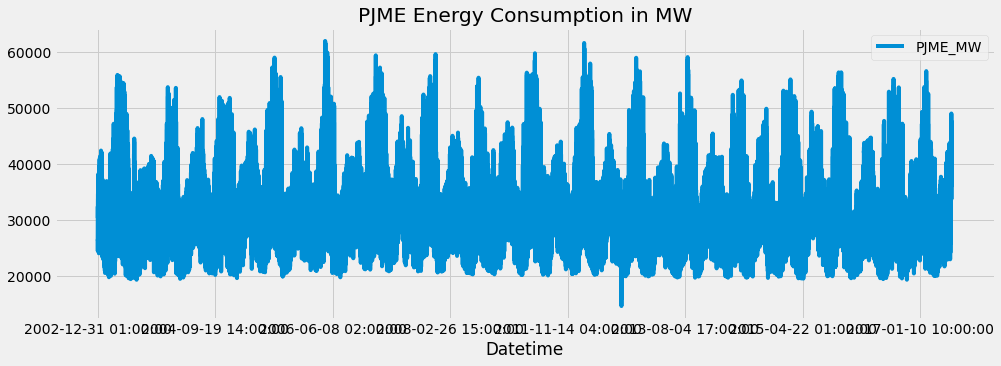

In [8]:
df.plot(figsize = (15, 5), color = color_pal[0], title = 'PJME Energy Consumption in MW')
plt.show()

In [9]:
# Let's explore the index
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

In [10]:
# The type of the index is object instead of datetime. Which needs to be fixed.

In [11]:
df.index = pd.to_datetime(df.index)

In [12]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

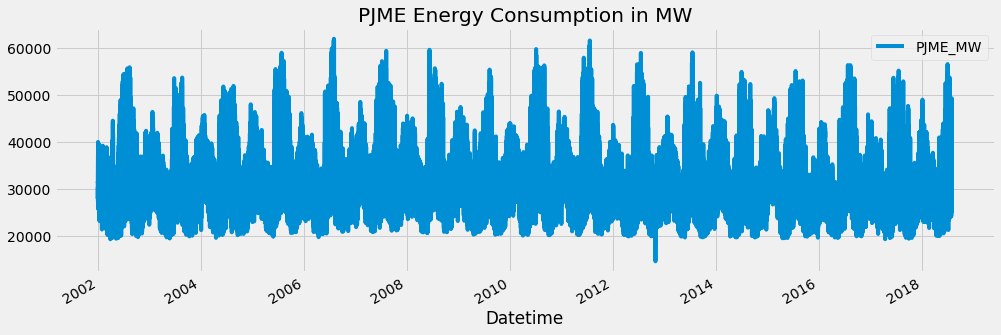

In [13]:
# Let't plot TS again and see how it looks
df.plot(figsize = (15, 5), 
        color = color_pal[0], 
        title = 'PJME Energy Consumption in MW')
plt.show()

## Outliers Analysis and Removal

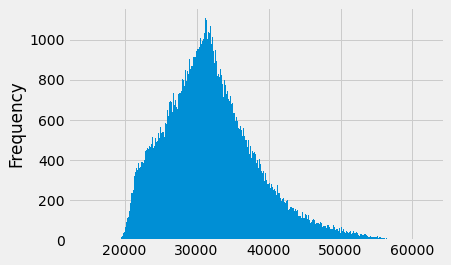

In [14]:
df['PJME_MW'].plot(kind = 'hist', bins = 500)
plt.show()

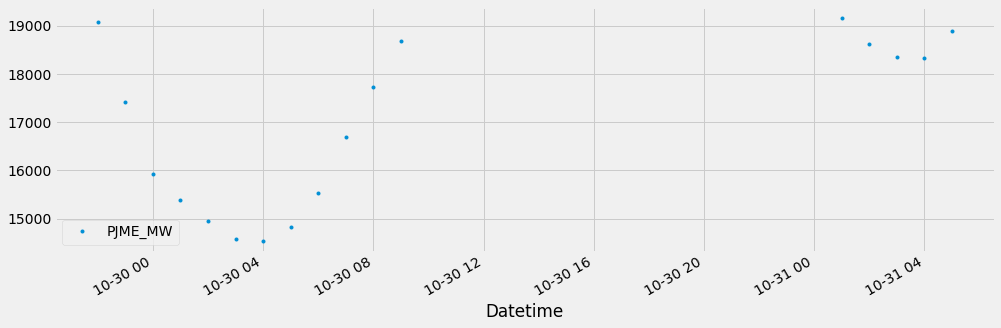

In [15]:
df.query('PJME_MW < 19247').plot(figsize = (15, 5), style = '.')
plt.show()

In [16]:
# Removing the outliers by querying the values PJME_MW > 19247
df = df.query('PJME_MW > 19247').copy()

## Time Series Cross Validation

In [17]:
from sklearn.model_selection import TimeSeriesSplit

In [18]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 24*365*1, gap = 24)
df = df.sort_index()

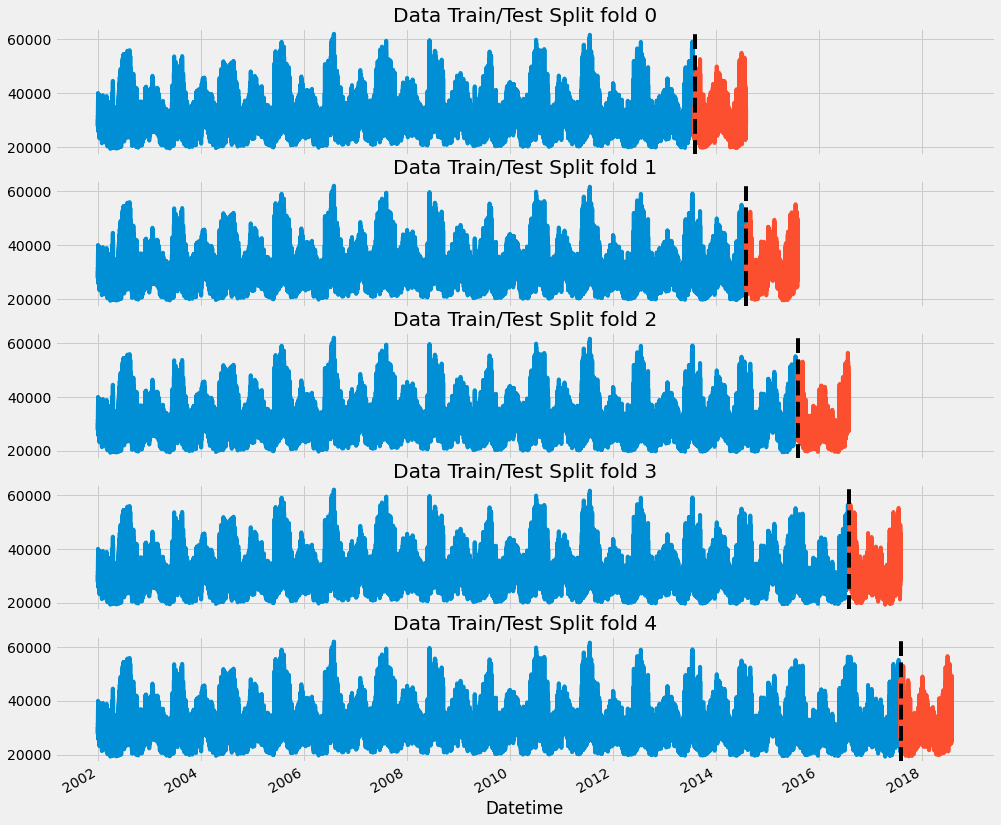

In [19]:
fig, axs = plt.subplots(5, 1, figsize = (15, 15),
                      sharex = True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold], label = 'Training set', title = f'Data Train/Test Split fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold], label = 'Testing set')
    axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
    
    fold += 1

## Feature Creation

In [20]:
def create_features(df):
    """ 
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df
df = create_features(df)


## Lag Features

In [21]:
def add_lags(df):
    
    '''This function create lag features. Notice that you cannot add 
    lag features back further than your Forecasting Horizon. Which is 
    the length of time into the future for which forecasts are to be prepared.
    These generally vary from short-term forecasting horizons (less than three
    months) to long-term horizons (more than two years)'''
    
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [22]:
df = add_lags(df)

In [23]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39525.0,38698.0,37330.0


## Train Using Cross Validation

In [24]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 24*365*1, gap = 24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'lag1', 'lag2', 'lag3']
    TARGET = 'PJME_MW'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree',
                          n_estimators = 1000,
                          early_stopping_rounds = 50,
                          objective = 'reg:linear',
                          max_depth = 3,
                          learning_rate = 0.01)
    reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[02:10:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.82166	validation_1-rmse:31956.64999
[100]	validation_0-rmse:12532.20017	validation_1-rmse:11907.59414
[200]	validation_0-rmse:5740.60408	validation_1-rmse:5352.49269
[300]	validation_0-rmse:3867.05089	validation_1-rmse:3895.95834
[400]	validation_0-rmse:3428.96173	validation_1-rmse:3757.68333
[451]	validation_0-rmse:3352.99527	validation_1-rmse:3763.77237
[02:10:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.45547	validation_1-rmse:32138.88572
[100]	validation_0-rmse:12513.37796	validation_1-rmse:12221.84118
[200]	validation_0-rmse:5755.21002	validation_1-rmse:5653.60807
[300]	validation_0-rmse:3903.54096	validation_1-rmse:3922.08244
[4

In [25]:
scores

[3757.522446881306,
 3422.3616107358016,
 3473.7238600517367,
 4125.381576607968,
 3995.7886354301804]

In [26]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold score {scores}')

Score across folds 3754.9556
Fold score [3757.522446881306, 3422.3616107358016, 3473.7238600517367, 4125.381576607968, 3995.7886354301804]


## Predicting the Future

In [27]:
# We will do the following to accomplish this:
# 1- Retrain the model on all the data
# 2- We need empty dataframe of the future data
# 3- Run this dataframe through our feature creation function + lag feature creation function

In [28]:
# 1- Retrain on all the data
df = create_features(df)
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'lag1', 'lag2', 'lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree',
                          n_estimators = 500,
                          early_stopping_rounds = 50,
                          objective = 'reg:linear',
                          max_depth = 3,
                          learning_rate = 0.01)
reg.fit(X_all, y_all, eval_set = [(X_all, y_all)], verbose=100)
    

[02:14:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32404.10693
[100]	validation_0-rmse:12426.51872
[200]	validation_0-rmse:5752.10739
[300]	validation_0-rmse:3971.74270
[400]	validation_0-rmse:3571.04735
[499]	validation_0-rmse:3455.08678


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [30]:
# 2- We need empty dataframe of the future data
future = pd.date_range(df.index.max(), '2019-08-01', freq = '1h')
future_df = pd.DataFrame(index = future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [31]:
df_and_future

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,40666.0,34555.0,34641.0,True


In [32]:
future_with_features = df_and_future.query('isFuture').copy()

In [33]:
# 3- Predicting the future
future_with_features['pred'] = reg.predict(future_with_features[FEATURES])

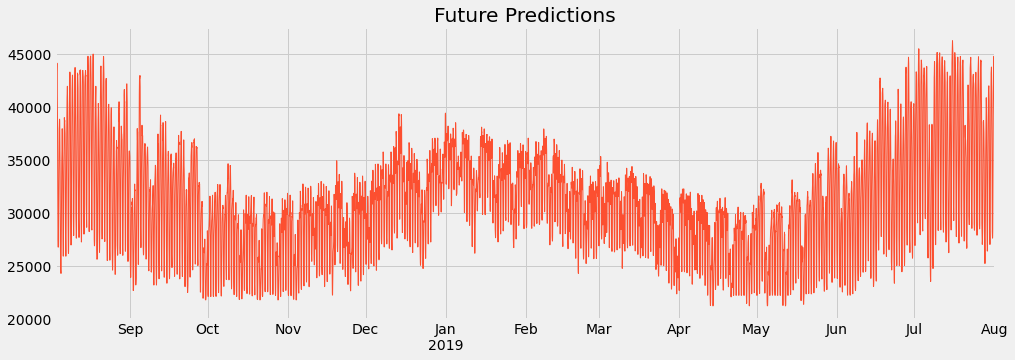

In [37]:
# Let's plot the predictions out to see what it looks like
future_with_features['pred'].plot(figsize = (15, 5), color = color_pal[1], ms = 1, lw = 1, title = 'Future Predictions')
plt.show()

### Feature Importance

In [38]:
fi = pd.DataFrame(data = reg.feature_importances_*100, 
                  index = reg.feature_names_in_,
                 columns = ['Importance'])

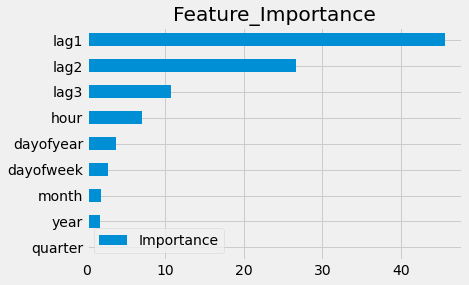

In [39]:
fi.sort_values('Importance').plot(kind = 'barh', title = 'Feature_Importance')
plt.show()

In [ ]:
# The Three lag features turned out to be really important to our model that I thought they would by.

## Saving the model for later

In [40]:
# Saving the model
reg.save_model('model.json')

In [44]:
# Loading the model again
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')

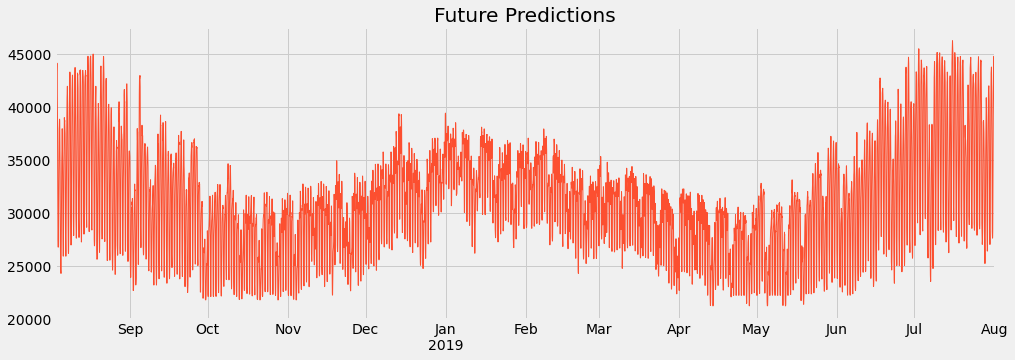

In [45]:
# Using the loaded model to predict the future also
future_with_features['pred'] = reg_new.predict(future_with_features[FEATURES])
future_with_features['pred'].plot(figsize = (15, 5), color = color_pal[1], ms = 1, lw = 1, title = 'Future Predictions')
plt.show()